Implementation of [Rodriguez](https://ieeexplore.ieee.org/document/5475260) (sec. IV A)

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# imports & constants
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from rodriguez import repeated_phase_DFT1, phase_estimation_DFT0
from math import ceil

In [68]:
# IV A. Visual Method
nominal_enf = 50  # Nominal ENF

In [69]:
# # (A) Import Audio
# path = "../data/raw/ENF-WHU-Dataset/enf_real_world_recordings/001.wav"

# # Laden der WAV-Datei
# f_s, s_raw = read(path)
# M = len(s_raw)
# print(f"f_s = {f_s} Hz")
# print(f"{M:_} samples")
# print(f"{M/f_s:.2f} seconds")
# print()

# # truncating to 60 seconds
# M = 60*f_s
# s_raw = s_raw[:M]
# print(f"{M:_} samples")
# print(f"{M/f_s:.2f} seconds")

In [70]:
# generate single tone
f_tone = 50.01
phi_0 = 0
amplitude = 1

f_s = 8_000
duration = 20
M = duration*f_s

n = np.arange(M)
s_raw = amplitude * np.cos(2 * np.pi * f_tone / f_s * n + phi_0)
del n, M

print(f"{len(s_raw):_} samples")
print(f"{len(s_raw)/f_s:.2f} seconds")

160_000 samples
20.00 seconds


In [71]:
# insert cut of ceil 1.25 nominal cycles
cutlen = ceil(1.25 * f_s / nominal_enf)

i = len(s_raw) // 2
mask = np.ones_like(s_raw, dtype=bool)
mask[i : i + cutlen] = False
s_raw = s_raw[mask]
del mask, i

In [72]:
# Step 1: Down-sample the audio signal
f_ds = 1_000

if f_s % f_ds == 0:
    downsample_factor = f_s // f_ds
    s_ds = signal.decimate(s_raw, downsample_factor)
else:
    raise NotImplementedError("Not implemented yet")
    # s_ds = signal.resample_poly(audio_signal, up=3, down=20)

print(f"{len(s_ds):_} samples")
print(f"{len(s_ds)/f_ds:.2f} seconds")

19_975 samples
19.98 seconds


In [73]:
# make skip filtering possible
s_enf = s_ds

In [74]:
# # plot the signal
# plt.plot(s_ds)
# plt.xlabel("Samples")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.show()

# # plot the signal fft
# plt.figure()
# plt.magnitude_spectrum(s_ds, Fs=f_ds, scale="dB")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Magnitude [dB]")
# plt.grid()
# plt.show()

In [75]:
# # Step 2: Design and apply FIR bandpass filter
# center_freq = nominal_enf
# passband_width = 1.4  # .6
# num_taps = 10_000
# band = [center_freq - passband_width / 2, center_freq + passband_width / 2]
# filter_taps = signal.firwin(num_taps, band, pass_zero=False, fs=f_ds) # f_s -> f_ds
# s_enf = signal.filtfilt(filter_taps, [1.0], s_ds)

# # delete samples at start and end
# s_enf[-num_taps // 2 :] = np.nan
# s_enf[: num_taps // 2] = np.nan

In [76]:
# # plot the signal
# plt.plot(s_enf)
# plt.xlabel("Samples")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.show()

# # plot the signal fft
# plt.figure()
# plt.magnitude_spectrum(s_enf, Fs=f_ds, scale="dB")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Magnitude [dB]")
# plt.grid()
# plt.show()

In [77]:
# Step 3: Segment the signal
num_cycles = 3

step_size = f_ds // nominal_enf # samples per nominal enf cycle
print(f"Samples per nominal enf cycle: {step_size:_}")
print(f"Samples per segment: {num_cycles*step_size:_}")

num_blocks = len(s_enf) // step_size - (num_cycles - 1)
print(f"Number of blocks: {num_blocks:_}")

segments = [s_enf[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

Samples per nominal enf cycle: 20
Samples per segment: 60
Number of blocks: 996


In [78]:
# plt.plot(segments[0])
# plt.show()

In [79]:
# Step 4: Estimate phase
phases = []
for segment in segments:
    N_DFT = len(segment)+1
    _, phase = phase_estimation_DFT0(segment, f_ds, N_DFT)
    phases.append(phase)

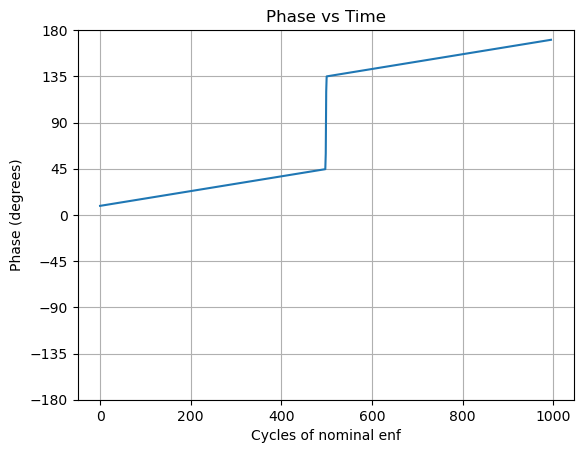

In [80]:
# Step 5: Plot phase values
x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.yticks(np.arange(-180, 181, 45))
plt.ylim(-180, 180)
plt.title("Phase vs Time")
plt.grid(True)
plt.show()